In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Загружаем и визуализируем данные 

Здесь мы скачиваем данные с гугл диска, при перезапуске нужно будет слегка переписать эти ячейки.

In [2]:
#!pip install PyDrive
#12mHyZlWqVjI4RPYr7EM9BwTi_ptw2j_
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/IDAO 2020.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()
#downloaded2 = drive.CreateFile({'id':"4/vgE_VWIwTwgnT4q89GJ8dBCj3GEzdDOwmVa4Asvj51zBM5zs_9or5y8"})
#downloaded2.GetContentFile('test.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!unzip -q "drive/My Drive/IDAO 2020.zip"

In [0]:
train = pd.read_csv('IDAO 2020/train.csv')

In [0]:
test = pd.read_csv('IDAO 2020/Track 1/test.csv')

In [6]:
train.shape, test.shape

((649912, 15), (284071, 9))

In [7]:
test.head(5)

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01T01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01T01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


Посмотрим распределение данных по спутникам

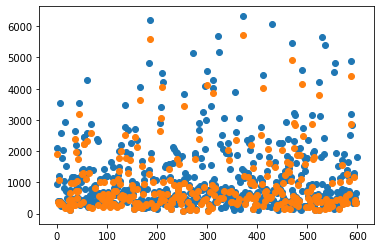

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

train_sat = Counter(train.sat_id)
test_sat = Counter(test.sat_id)
plt.scatter(train_sat.keys(), train_sat.values())
plt.scatter(test_sat.keys(), test_sat.values())

In [12]:
chislo_vhojdeniy = []
for sat in set(train_sat).intersection(set(test_sat)):
  chislo_vhojdeniy.append((train_sat[sat]/test_sat[sat] - 1) * 100)



print("В среднем в train число вхождений больше на {0}%".format(sum(chislo_vhojdeniy)/ len(chislo_vhojdeniy)))
print("Максимальное число вхождений в train больше на {0}%".format(max(chislo_vhojdeniy)))
print("Минимальное число вхождений в train больше на {0}%".format(min(chislo_vhojdeniy)))

В среднем в train число вхождений больше на 11.22589449317023%
Максимальное число вхождений в train больше на 18.627450980392158%
Минимальное число вхождений в train больше на 10.169491525423723%


Из приведенной статистики видно, что в среднем нет сильных расхождений по числу вхождений на обучающей и тестовой выборках. В среднем на 11% больше вхождений на обучающей выборке. Что в первую очередь связано с тем что в трейне данные за январь, а в тесте за февраль, а дней в февралей меньше.

Посмотрим какие спутники встречаются и в трейне и в тесте, а какие нет. Ровно половина спутников есть и в трейне и в тесте, другая половина есть только в трейне. 

In [13]:
print(f'Всего в трейне {len(set(train_sat))}')
print(f'Всего в тесте {len(set(test_sat))}')
print(f'Пересечений {len(set(train_sat).intersection(set(test_sat)))}')
print(f'Есть только в трейне {len(set(train_sat).difference(set(test_sat)))}')
print(f'Есть только в тесте {len(set(test_sat).difference(set(train_sat)))}')

Всего в трейне 600
Всего в тесте 300
Пересечений 300
Есть только в трейне 300
Есть только в тесте 0


Базовое решение (просто реальные=симулированным координатам) предоставленное организаторами.

In [14]:
submission = pd.read_csv('IDAO 2020/Track 1/submission.csv')
submission.head()

,id,x,y,z,Vx,Vy,Vz
0,3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [15]:
test.head()

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01T01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01T01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


Данные по спутникам очень не сбалансированы - есть спутники по 5700 наблюдений а есть по 100.

In [17]:
train_id = Counter(train.sat_id)
test_id = Counter(test.sat_id)
percent_id = Counter({i: test_id[i]/train_id[i] for i in test_id})

test_id.most_common(5)

[(372, 5707), (186, 5601), (470, 4923), (588, 4413), (489, 4149)]

Рассмотрев как соотносятся реальные данные с симулированными, было обнаружено, что часть спутников достаточно четко описывается симулированными данными, а часть имеет достаточно консервативную оценку и чаще всего просто попадает в область одной и той же точки. 

*В дальнейшем мы обнаружим что даже там где визульно все хорошо - симулированные данные сильно ошибаются с кластерами.

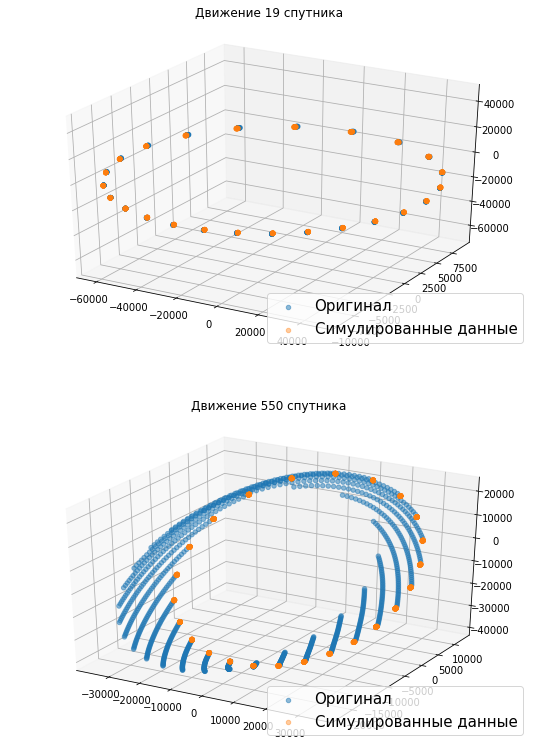

In [19]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=plt.figaspect(0.5))
plt.subplots_adjust(left=0.0, right=2.0, bottom=-1.5, top=1.0)
ax = fig.add_subplot(222, projection='3d')
criteria = (train.sat_id == 19)
criteria1 = (train.sat_id == 550)

  
ax.scatter(train[criteria].x, 
             train[criteria].y, 
             train[criteria].z, 
             label='Оригинал', alpha=0.5)
  
ax.scatter(train[criteria].x_sim, 
             train[criteria].y_sim, 
             train[criteria].z_sim, 
             label='Симулированные данные', alpha=0.4)
 
  
ax.legend(loc='lower right', fontsize = 15)
ax.title.set_text('Движение 19 спутника')

ax= fig.add_subplot(224, projection='3d')
ax.scatter(train[criteria1].x, 
             train[criteria1].y, 
             train[criteria1].z, 
             label='Оригинал', alpha=0.5)
  
ax.scatter(train[criteria1].x_sim, 
             train[criteria1].y_sim, 
             train[criteria1].z_sim, 
             label='Симулированные данные', alpha=0.4)

ax.legend(loc='lower right', fontsize = 15)
ax.title.set_text('Движение 550 спутника')

Уже визуально кажется что точки вырисовываются в некие линии и кажется что есть некие кластера точек

DBSCAN и перебор показал, что все спутники имеют 24 кластера и это особенность данных которую стоит использовать. (Уже даст буст где то до 86 на паблике)

In [21]:
# Центр траектории рассчитывается как середина отрезка апроксимации диаметра, которая в свою очередь является наибольшим расстоянием между люыми двумя точками в траектории движения спутнка 
def center(sat_id):
  sputnik1 = train[train["sat_id"] == sat_id]
  fst_id = sputnik1.id.iloc[0]
  sputnik1.id = sputnik1.id - fst_id
  Q1 = np.hstack([np.array(sputnik1['x']).reshape(-1,1), np.array(sputnik1['y']).reshape(-1,1),
                  np.array(sputnik1['z']).reshape(-1,1)])
  c = []
  j = sputnik1.sort_values(by='distance to Earth',ascending=False).id.iloc[0]
  for i in range(j, len(Q1)):
      distance = ((Q1[:,:1][i] - Q1[:,:1][j] ) ** 2 + (Q1[:,1:2][i] - Q1[:,1:2][j]) ** 2 + (Q1[:,2:][i] - Q1[:,2:][j]) ** 2 ) ** (1/2)
      c.append((distance, i))
  c.sort(key=lambda x: x[0])
  return ((np.array(sputnik1['x'])[j] + np.array(sputnik1['x'])[c[-1][1]]) / 2, 
         (np.array(sputnik1['y'])[j] + np.array(sputnik1['y'])[c[-1][1]]) / 2,
         (np.array(sputnik1['z'])[j] + np.array(sputnik1['z'])[c[-1][1]]) / 2,
         c[-1][0][0])

train['distance to Earth'] = (train.x_sim ** 2 + train.y_sim ** 2 + train.z_sim ** 2) ** 0.5
test['distance to Earth'] = (test.x_sim ** 2 + test.y_sim ** 2 + test.z_sim ** 2) ** 0.5

center_coord = dict()
for i in train_sat:
  center_coord[i] = center(i)

train['x_center'] = train.sat_id.apply(lambda x: center_coord[x][0])
train['y_center'] = train.sat_id.apply(lambda x: center_coord[x][1])
train['z_center'] = train.sat_id.apply(lambda x: center_coord[x][2])
test['x_center'] = test.sat_id.apply(lambda x: center_coord[x][0])
test['y_center'] = test.sat_id.apply(lambda x: center_coord[x][1])
test['z_center'] = test.sat_id.apply(lambda x: center_coord[x][2])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


563.731463586366
Estimated number of clusters: 24
Estimated number of noise points: 0


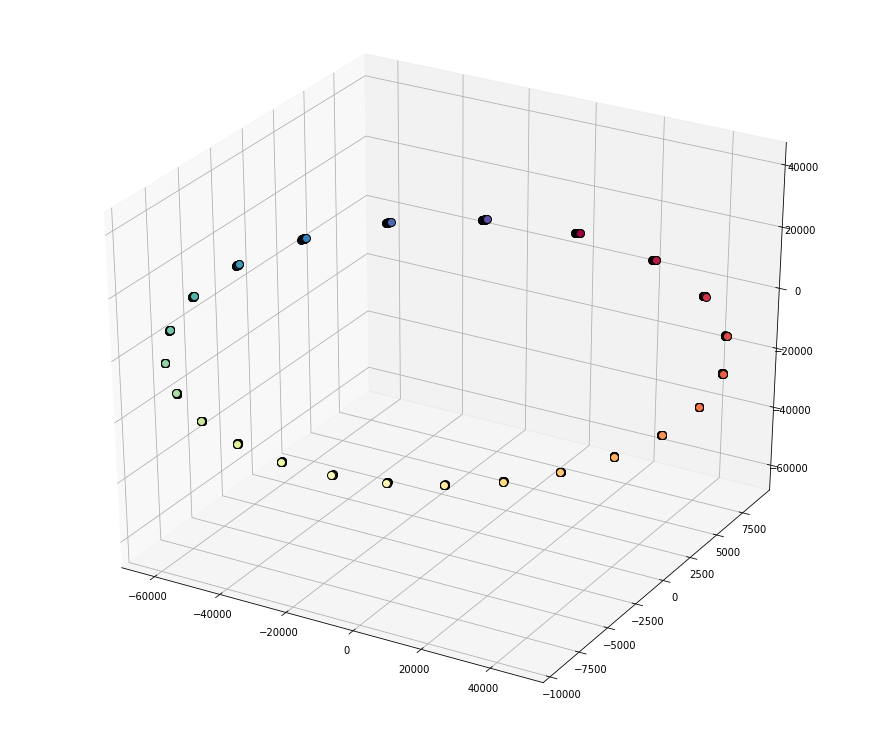

In [22]:
from sklearn.cluster import DBSCAN
from matplotlib.colors import Normalize



train['max_diametr'] = train.sat_id.apply(lambda x: center_coord[x][3])
test['max_diametr'] = test.sat_id.apply(lambda x: center_coord[x][3])

def cluster_show(sat_id=1):
  y = np.array([train[train.sat_id==sat_id].x, train[train.sat_id==sat_id].y, train[train.sat_id==sat_id].z]).T
  db = DBSCAN(eps=(train[train.sat_id==sat_id].max_diametr ** 0.5).iloc[0], min_samples=1).fit(y)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  print((train[train.sat_id==sat_id].max_diametr /200).iloc[0])
  

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print('Estimated number of clusters: %d' % n_clusters_)
  print('Estimated number of noise points: %d' % n_noise_)

  unique_labels = set(labels)
  colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]


  fig = plt.figure()
  plt.subplots_adjust(left=0.0, right=2.0, bottom=-1.5, top=1.0)
  ax = fig.add_subplot(111, projection='3d')
  for k, col in zip(unique_labels, colors):
      if k == -1:
          # Black used for noise.
          col = [0, 0, 0, 1]

      class_member_mask = (labels == k)

      xy = y[class_member_mask & core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=8)

      xy = y[class_member_mask & ~core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)

  plt.show()

cluster_show(19)

Начертим 3d проекцию движения спутника. Случайно заметил интересную особенность у 100 спутника - симуляция менее четко описывает движение, предсказывая практически только последнюю точку.

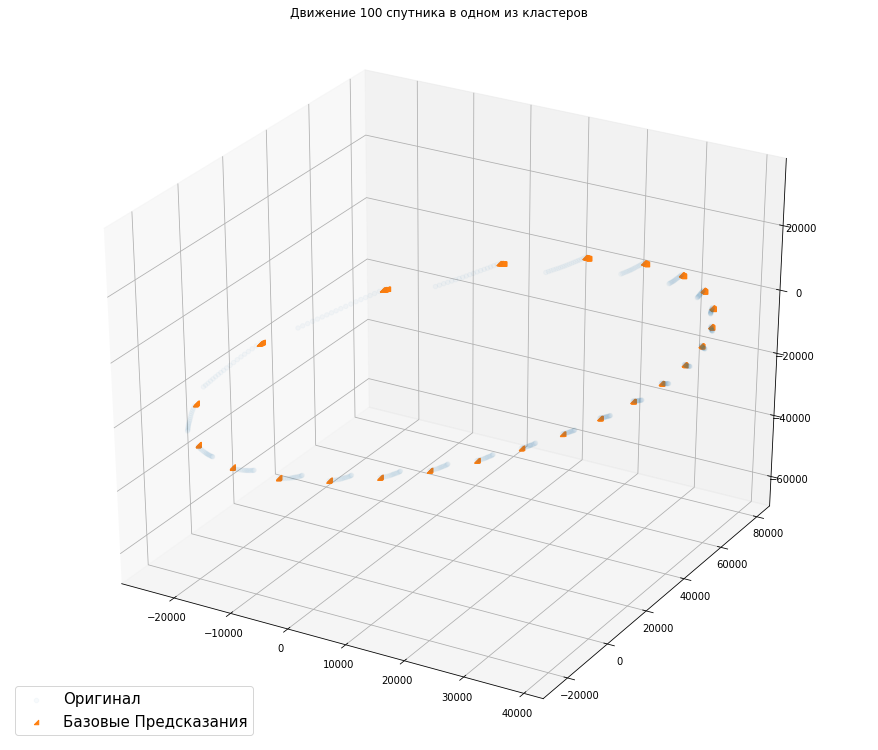

In [32]:
from mpl_toolkits.mplot3d import axes3d, Axes3D


def plot_path(sat=1, prediction=None, flag=False, flag2=False, prediction2=None):
  fig = plt.figure()
  plt.subplots_adjust(left=0.0, right=2.0, bottom=-1.5, top=1.0)
  ax = fig.add_subplot(111, projection='3d')
  criteria = (train.sat_id == sat)
  
  ax.scatter(train[criteria].x, 
             train[criteria].y, 
             train[criteria].z, 
             label='Оригинал', alpha=0.03)

  criteria_test = (test.sat_id == sat)
  verts = np.array([[-1, -1], [1, -1], [1, 1], [-1, -1]])
  if flag:
    ax.scatter(prediction[:, 0], 
               prediction[:, 1], 
               prediction[:, 2], 
               label='Базовые Предсказания', marker=verts)
  if flag2:
    ax.scatter(prediction2[:, 0], 
               prediction2[:, 1], 
               prediction2[:, 2], 
               label='Улчшенные Предсказания')
  ax.legend(loc='lower left', fontsize = 15)
  ax.title.set_text(f'Движение {sat} спутника в одном из кластеров')
  plt.show()
  

plot_path(100, np.array(train[train.sat_id == 100][['x_sim', 'y_sim', 'z_sim']]), True)


# Делаем дополнительные фичи из данных

Есть несколько идей для фичей


Для начала вытащим все базовые временные показатели.

In [33]:
train['epoch'] = pd.to_datetime(train['epoch'], format='%Y-%m-%dT%H:%M:%S.%f')
test['epoch'] = pd.to_datetime(test['epoch'], format='%Y-%m-%dT%H:%M:%S.%f')
train["year"] = train["epoch"].dt.year
test["year"] = test["epoch"].dt.year
train["month"] = train["epoch"].dt.month
test["month"] = test["epoch"].dt.month
train["day"] = train["epoch"].dt.day
test["day"] = test["epoch"].dt.day
train["hour"] = train["epoch"].dt.hour
test["hour"] = test["epoch"].dt.hour
train["minute"] = train["epoch"].dt.minute
test["minute"] = test["epoch"].dt.minute
train["weekday"] = train["epoch"].dt.weekday
test["weekday"] = test["epoch"].dt.weekday
train.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,distance to Earth,x_center,y_center,z_center,max_diametr,year,month,day,hour,minute,weekday
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,26096.521772,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,0,0,2
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,26703.386480,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,0,46,2
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,28351.260474,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,1,33,2
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,30659.611188,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,2,20,2
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,33247.520541,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,3,6,2


Смотрим на время между замерами спутников

In [34]:
train['x_sim_prev'] = train['x_sim'].shift(1)
train['y_sim_prev'] = train['y_sim'].shift(1)
train['z_sim_prev'] = train['z_sim'].shift(1)
train['Vx_sim_prev'] = train['Vx_sim'].shift(1)
train['Vy_sim_prev'] = train['Vy_sim'].shift(1)
train['Vz_sim_prev'] = train['Vz_sim'].shift(1)
train['time_from_previous'] = train.epoch - train['epoch'].shift(1) ## Эту штуку надо поправить -  он считает время и между разными спутниками

train['minute_from_previous'] = train['time_from_previous'].dt.components['minutes']
train['second_from_previous'] = train['time_from_previous'].dt.components['seconds'] + train['time_from_previous'].dt.components['minutes'] * 60 + train['time_from_previous'].dt.components['hours'] * 3600

test['x_sim_prev'] = test['x_sim'].shift(1)
test['y_sim_prev'] = test['y_sim'].shift(1)
test['z_sim_prev'] = test['z_sim'].shift(1)
test['Vx_sim_prev'] = test['Vx_sim'].shift(1)
test['Vy_sim_prev'] = test['Vy_sim'].shift(1)
test['Vz_sim_prev'] = test['Vz_sim'].shift(1)
test['time_from_previous'] = test.epoch - test['epoch'].shift(1)
test['minute_from_previous'] = test['time_from_previous'].dt.components['minutes']
test['second_from_previous'] = test['time_from_previous'].dt.components['hours'] * 3600+ test['time_from_previous'].dt.components['minutes'] * 60+ test['time_from_previous'].dt.components['seconds']

#train = train.fillna(np.inf)
train.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,distance to Earth,x_center,y_center,z_center,max_diametr,year,month,day,hour,minute,weekday,x_sim_prev,y_sim_prev,z_sim_prev,Vx_sim_prev,Vy_sim_prev,Vz_sim_prev,time_from_previous,minute_from_previous,second_from_previous
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,26096.521772,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,26703.386480,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,0,46,2,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,00:46:43,46.0,2803.0
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,28351.260474,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,1,33,2,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,00:46:43.001000,46.0,2803.0
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,30659.611188,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,2,20,2,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,00:46:43,46.0,2803.0
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,33247.520541,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,3,6,2,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,00:46:43.001000,46.0,2803.0


Заметим что есть некоторые странные спутники с почти дублированными координатами. Также очень важно не забыть что и в тесте есть подобные дубликаты - и их тоже нельзя игнорировать(понятно что их нельзя выкинуть)!!!

In [35]:
from collections import Counter 

Counter(test[test.second_from_previous==0].sat_id).most_common(10)

[(476, 5),
 (504, 5),
 (4, 4),
 (82, 4),
 (98, 4),
 (118, 4),
 (133, 4),
 (230, 4),
 (437, 4),
 (498, 4)]

В одном только тесте есть до 5 таких наблюдений где время между ними отличается менее чем на секунду, такие точки получаются по факту дубликатами и надо очень аккуратно их обработать, сделаем это так - если у наблюдения есть дубликаты то у этих наблюдений должен быть одинаковый id, в трейне разумно будет просто выкинуть такие наблюдения и сместить id чтобы они шли ровно по порядку. А в тесте надо будет им всем возвращать одинаковое предсказание. 

Почистим почти дублирующие точки - где second_from_previous == 0 обработав их id. Проверять будем построчно, предварительно слив трейн и тест.

In [0]:
minus_id = 0 #глобальная переменная отвечающая за размер смещения при встрече с дубликатом
def clean_duplicates(raw):
  """
  На вход принимает строку и при необходимости уменьшает в нем id.
  При прогоне Dataframe через эту функцию мы получим его id в следующем виде:
  1) У следующего наблюдений если оно уникально и не дубликат id больше ровно на 1
  2) Если следующее наблюдение является дубликатом текущего то у него будет такой же id как у данного наблюдения

  """
  global minus_id

  #print(raw)
  if raw.second_from_previous == 0.0:
    minus_id += 1
  
  raw['id'] -= minus_id
  return raw



Объединим трейн и тест, почистим в них id указанным способом и введем признак кластера в данные. Всего в спутниках 24 кластера как было установлено ранее, и если исключить дубликаты то точки одного кластера - каждая 24 точка, что можно заметить если посмотреть на данные. 

In [0]:

minus_id = 0
train["Series_name"] = train.id * 0 + 1 # признаки по которым мы вернем значения id отдельно в трейн и не перепутаем его с тестом
test["Series_name"] = test.id * 0 # тоесть у трейна в данном признаке 1 а у теста 0 
df = pd.concat([train[['id', 'sat_id', 'second_from_previous', 'x_sim', 'y_sim', 'z_sim', 'Series_name', 'epoch']], 
                test[['id', 'sat_id', 'second_from_previous', 'x_sim', 'y_sim', 'z_sim', 'Series_name', 'epoch']]]).reset_index().sort_values(by=['sat_id', 'id']).reset_index(drop=True)
# сливаем трейн и тест сохранив их индексы и упорядочив по id, они там идеально наложатся
df['time_from_previous'] = df.epoch - df['epoch'].shift(1) # пересчитаем в слитом трейне и и тесте время между наблюдениями
df['second_from_previous'] = df['time_from_previous'].dt.components['hours'] * 3600+ df['time_from_previous'].dt.components['minutes'] * 60+ df['time_from_previous'].dt.components['seconds']
df['row_id'] = df.id * 1
df = df.apply(clean_duplicates, axis=1)
df['cluster'] = df.id % 24 # методом тыка было замечено что кластеризация по такому признаку очень хорошая, далее мы это увидим


Теперь вернем признак кластера в трейн и тест

In [0]:

test["cluster"] = df[df.Series_name == 0].sort_values(by='index').reset_index(drop=True).cluster
train["cluster"] = df[df.Series_name == 1].sort_values(by='index').reset_index(drop=True).cluster


Визуально оценим полученную кластеризацию, а заодно и посмотрим на качество симулированных данных

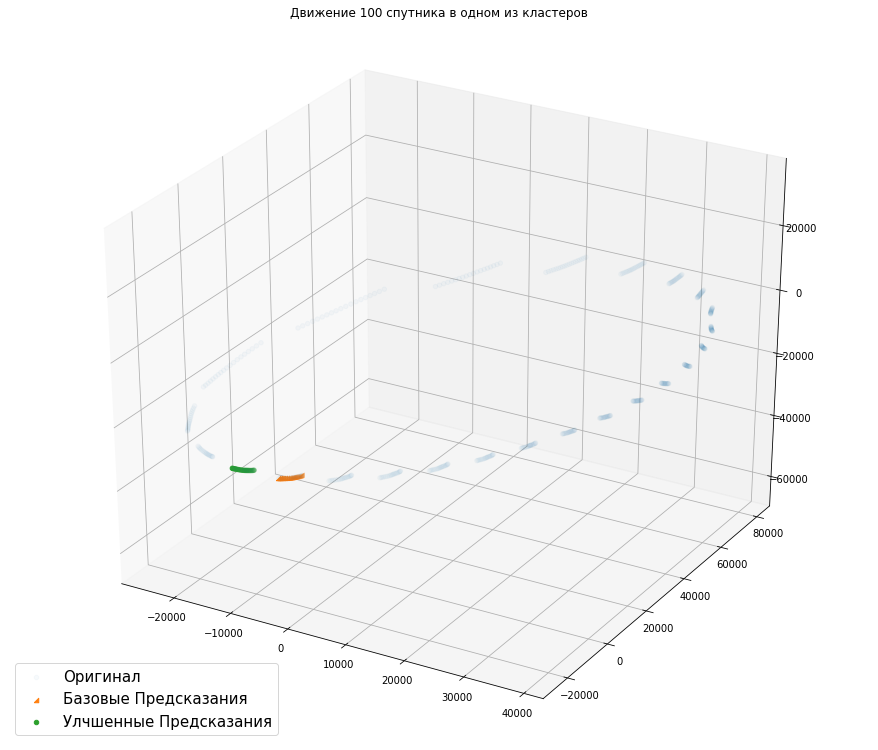

In [46]:

i = 100
plot_path(i, np.array(train[(train.sat_id==i) & (train.cluster==3)][['x','y','z']]), True, True, np.array(train[(train.sat_id==i) & (train.cluster==4)][['x','y','z']]))


На примере 100 спутника видно что 3 и 4 кластер точно хорошо найдены. Теперь проверим что говорят сим данные в одном кластере на этом же примере.

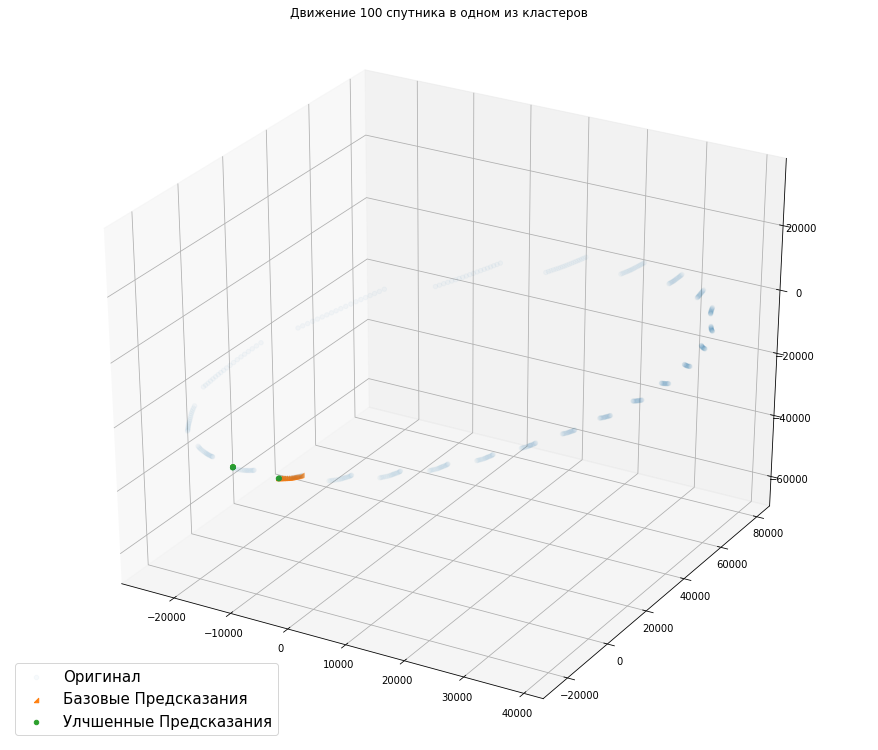

Точек дубликатов -  1


In [49]:
i = 100
plot_path(i, np.array(train[(train.sat_id==i) & (train.cluster==3)][['x','y','z']]), True, True, np.array(train[(train.sat_id==i) & (train.cluster==3)][['x_sim','y_sim','z_sim']]))
print("Точек дубликатов - ", Counter(train[train.second_from_previous==0].sat_id)[100])

Видно что симулированные данные для одного кластера почему то предсказывают нужный кластер но в какой то момент начинают предсказывать соседний. Также заметим что в 100 спутнике ровно 1 дубликат. 

Опять же методом очень пристального взгляда было выявлено что сим данные сбиваются на дубликатах - они считают его отдельным наблюдением и если бы мы не учли их то тоже бы давали неверный кластер.

Отсюда вывод - чем больше дубликатов тем больше ошибка сим данных. А так как дубликаты есть практически везде - сим данным вообще лучше не верить и не использовать их при обучении.

Первый предиктор будет основан на том что будет правильно предсказывать кластер - его smape на тесте уже 85. Тоесть если просто угадывать нужный кластер, даже не задумываясь о внутрикластерном движении и смещении спутника, это уже даст хороший скор 

Теперь правильно определив кластера - создадим такой признак как id внутри кластера чтобы предсказывать внутрикластерное смещение потом. Начиная от 1 и пока точки в кластере конкретного спутника не кончатся

In [51]:
import copy

df['cluster_id'] = df.cluster * 0


df['new_index'] = df.index
for sat_num in set(train_sat):
  for clus_num in range(24):

    cluster_data = df[(df.cluster == clus_num) & (df.sat_id == sat_num)].reset_index(drop=True).reset_index()
    df.loc[cluster_data['new_index'],'cluster_id'] = copy.deepcopy(cluster_data.set_index(cluster_data['new_index']).level_0)



df.tail()


,index,id,sat_id,second_from_previous,x_sim,y_sim,z_sim,Series_name,epoch,time_from_previous,row_id,cluster,cluster_id,new_index
933978,649907,1233357,599,1490.0,-20717.958996,-16245.240500,5250.939232,1,2014-01-31 22:00:22.602,00:24:50.637000,1234089,21,74,933978
933979,649908,1233358,599,1490.0,-22673.444496,-11192.339393,5243.608790,1,2014-01-31 22:25:13.240,00:24:50.638000,1234090,22,74,933979
933980,649909,1233359,599,1490.0,-23461.830699,-5570.167175,4966.813869,1,2014-01-31 22:50:03.878,00:24:50.638000,1234091,23,74,933980
933981,649910,1233360,599,1490.0,-22858.679929,373.249102,4396.055679,1,2014-01-31 23:14:54.515,00:24:50.637000,1234092,0,74,933981
933982,649911,1233361,599,1490.0,-20656.328603,6277.934683,3518.642806,1,2014-01-31 23:39:45.153,00:24:50.638000,1234093,1,74,933982


In [0]:
test["cluster_id"] = df[df.Series_name == 0].sort_values(by='index').reset_index(drop=True).cluster_id
train["cluster_id"] = df[df.Series_name == 1].sort_values(by='index').reset_index(drop=True).cluster_id


Мы знаем все точки в кластере конкретного спутника, создадим признак - смещение до следующей точки данного кластера данного спутника.

* Считать будем как например - у 591 спутника 20 кластера 6 точки в кластере он будет таким : 

искомые переменные 591 спутника 20 кластера 7 точки в кластере - искомые переменные 591 спутника 20 кластера 6 точки в кластере 

* Искомые переменные - координаты x y z и скорости Vx Vy Vz

In [53]:
train['x_shift'] = train.x * 0
train['y_shift'] = train.x * 0
train['z_shift'] = train.x * 0
train['Vx_shift'] = train.x * 0
train['Vy_shift'] = train.x * 0
train['Vz_shift'] = train.x * 0

train['new_index'] = train.index

for sat_num in set(train_sat):
  for clus_num in range(24):
    cluster_data = train[(train.cluster == clus_num) & (train.sat_id == sat_num)]#.reset_index(drop=True).reset_index()
    train.loc[cluster_data.index, 'x_shift'] = -cluster_data['x'] + cluster_data['x'].shift(-1)
    train.loc[cluster_data.index, 'y_shift'] = -cluster_data['y'] + cluster_data['y'].shift(-1)
    train.loc[cluster_data.index, 'z_shift'] = -cluster_data['z'] + cluster_data['z'].shift(-1)
    train.loc[cluster_data.index, 'Vx_shift'] = -cluster_data['Vx'] + cluster_data['Vx'].shift(-1)
    train.loc[cluster_data.index, 'Vy_shift'] = -cluster_data['Vy'] + cluster_data['Vy'].shift(-1)
    train.loc[cluster_data.index, 'Vz_shift'] = -cluster_data['Vz'] + cluster_data['Vz'].shift(-1)

train.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,distance to Earth,x_center,y_center,z_center,max_diametr,year,month,day,hour,minute,weekday,x_sim_prev,y_sim_prev,z_sim_prev,Vx_sim_prev,Vy_sim_prev,Vz_sim_prev,time_from_previous,minute_from_previous,second_from_previous,Series_name,cluster,cluster_id,x_shift,y_shift,z_shift,Vx_shift,Vy_shift,Vz_shift,new_index
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,26096.521772,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,1,0,0,9.470047,33.528212,19.588008,-0.002515,0.002630,-0.004373,0
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,26703.386480,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,0,46,2,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,00:46:43,46.0,2803.0,1,1,0,2.076431,37.559422,6.630411,-0.002646,0.000254,-0.004653,1
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,28351.260474,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,1,33,2,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,00:46:43.001000,46.0,2803.0,1,2,0,-4.837446,35.463580,-5.494772,-0.002223,-0.001605,-0.003882,2
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,30659.611188,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,2,20,2,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,00:46:43,46.0,2803.0,1,3,0,-10.202979,29.395817,-14.822060,-0.001597,-0.002590,-0.002765,3
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,33247.520541,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,3,6,2,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,00:46:43.001000,46.0,2803.0,1,4,0,-13.824680,21.537821,-21.102183,-0.001002,-0.002938,-0.001749,4


На случай краша сохраним все train и test фичи в csv.

In [0]:
train.to_csv('final_train.csv')
test.to_csv('final_test.csv')

In [0]:
import pandas as pd
import numpy as np

train = pd.read_csv('final_train.csv')
test = pd.read_csv('final_test.csv')

In [56]:
train.head(1)

,Unnamed: 0,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,distance to Earth,x_center,y_center,z_center,max_diametr,year,month,day,hour,minute,weekday,x_sim_prev,y_sim_prev,z_sim_prev,Vx_sim_prev,Vy_sim_prev,Vz_sim_prev,time_from_previous,minute_from_previous,second_from_previous,Series_name,cluster,cluster_id,x_shift,y_shift,z_shift,Vx_shift,Vy_shift,Vz_shift,new_index
0,0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.22169,-20741.615306,-0.907527,-3.80493,-2.024133,26096.521772,11051.665716,-5060.583985,25619.243629,57968.676006,2014,1,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,9.470047,33.528212,19.588008,-0.002515,0.00263,-0.004373,0


# Создаем 4 алгоритма предсказателя и применяем их в стакинге

In [0]:
train = train.sort_values(by=['day', 'id']) # сортируем данные для time based сплита
train = train.fillna(0) 
train = train[train.second_from_previous != 0.0] # выкидываем дубликаты из трейна

features = [train.sat_id,
            train.x,
            train.y,
            train.z,
            train.Vx,
            train.Vy,
            train.Vz,
            train.id,
            train.day,
            train.year,
            train.month,
            train.hour,
            train.minute,
            train.weekday,
            train.minute_from_previous,
            train.x_shift,
            train.y_shift,
            train.z_shift,
            train.Vx_shift,
            train.Vy_shift,
            train.Vz_shift,
            train.second_from_previous,            
            train.cluster,
            train.cluster_id]


y = np.array([train.x, train.y, train.z, train.Vx, train.Vy, train.Vz]).T

df = np.array(features).T

Реализуем функцию подсчета скора как написали организаторы и проверим ее работоспособность на сим данных.

In [58]:
def smape(satellite_predicted_values, satellite_true_values):
    #print(satellite_predicted_values)
    # the division, addition and subtraction are pointwise 
    return 100 * (1 - np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values)))))
    
smape(np.array([train.x, train.y, train.z, train.Vx, train.Vy, train.Vz]).T, 
      np.array([train.x_sim, train.y_sim, train.z_sim, train.Vx_sim, train.Vy_sim, train.Vz_sim]).T)

81.28806685867104

Для данной задачи нужен Time based cross validation, так как тестовые данные это следующий месяц и для объективной оценки нам тоже надо предсказывать будущее по старым данным

In [59]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(3) # мало сплитов потому что по некоторым спутникам слишком мало наблюдений
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df[train_index], df[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [     0      1      2 ... 162352 162353 162354] TEST: [162355 162356 162357 ... 324705 324706 324707]
TRAIN: [     0      1      2 ... 324705 324706 324707] TEST: [324708 324709 324710 ... 487058 487059 487060]
TRAIN: [     0      1      2 ... 487058 487059 487060] TEST: [487061 487062 487063 ... 649411 649412 649413]


In [60]:


tscv = TimeSeriesSplit(3)

for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df[train_index], df[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

   

TRAIN: [     0      1      2 ... 162352 162353 162354] TEST: [162355 162356 162357 ... 324705 324706 324707]


Теперь данные подготовлены и можно начинать писать алгоритмы предсказывания. 

Бейзлайн алгоритм на вход получает (по факту получает больше, но предсказывает только по этим двум переменным) кластер и спутник, а выдает последнюю координату спутника в этом кластере. Он вообще статично предсказывает 24 точки для каждого спутника и считает что они не смещаются.

In [0]:
from sklearn.base import BaseEstimator
import numpy as np
import random
from collections import Counter
from tqdm import tqdm


class Astro_Predictor(BaseEstimator):
    def __init__(self):
        self.sat = None # словарь всех спутников где в каждом спутнике хранятся последние 24 точки в каждом из кластеров

    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l) - не будет использоваться
        
        output: self
        """
        self.sat = dict(Counter(X[:, 0]))

        for sat in self.sat:
          data = (X[X[:, 0] == sat])[-24:, :]
          coord_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
          for clus in coord_dict:
            coord_dict[clus] = (data[data[:, -2] == clus])[:, 1:7]

          
      
          self.sat[sat] = coord_dict

        return self
    
    def predict(self, X):
        """
        X: np.array of shape (l, d)
        
        output: y, np.array of shape (l)
        """
        if self.sat is None:
            raise Exception('Not trained yet')
        prediction = np.ones((X.shape[0], 6))
        for i in range(X.shape[0]):
          row = X[i]
          base = self.sat[row[0]][row[-2]]
          prediction[i] = base
        
        return prediction

In [69]:
astro_model = Astro_Predictor()
astro_model.fit(X_train, y_train)
prediction = astro_model.predict(X_test)
#X_test[0]
smape(prediction, y_test)

90.71864402813814

Для такого условно легкого алгоритма получился неплохой скор. Проверим его на кросс валидации:

In [63]:
from sklearn.linear_model import Lasso
import warnings

warnings.simplefilter("ignore")

for train_index, test_index in tscv.split(df):
    X_train, X_test = df[train_index], df[test_index]
    y_train, y_test = y[train_index], y[test_index]

    astro_model = Astro_Predictor()
    astro_model.fit(X_train, y_train)
    print(smape(y_test, astro_model.predict(X_test)))

92.16492278115075
91.41471197016243
90.71864402813814


Понятно что чем длинее временной промежуток тем сильнее точки смещаются внутри кластера и тем хуже скор, но он все равно достаточно высок. Внизу код - который демонстрирует скор базового алгоритма по всем спутникам. Подавляющему большинству спутников оченб неплохо но если смещение в кластере сильное то скор становится низким

Average train score -  94.4985864492734
Average test score -  94.36710493801144
Min train score -  31.284949670836216 249
Min test score -  32.61983084784366 523


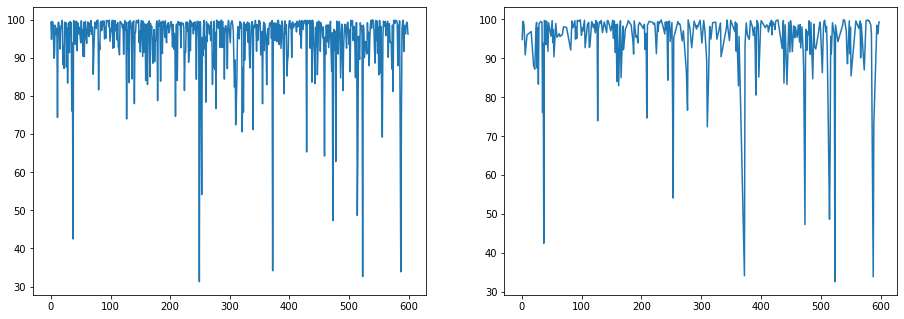

In [64]:
train_score = []
test_score = []
for i in set(train_sat):
  score = smape(astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i])
  train_score.append(score)
  if i in test_sat:
    test_score.append(score)


fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(left=0.0, right=2.0, bottom=0.0, top=1.0)



axs[0].plot(list(train_sat.keys()), train_score)
axs[1].plot(list(test_sat.keys()), test_score)
print('Average train score - ', sum(train_score) / len(train_score))
print('Average test score - ', sum(test_score) / len(test_score))
print('Min train score - ', min(train_score),  train_score.index(min(train_score)))
print('Min test score - ', min(test_score),  train_score.index(min(test_score)))


Посмотрим на один из таких спутников(473) внутри 9 кластера:

Скор этого спутника 47.28683523899494


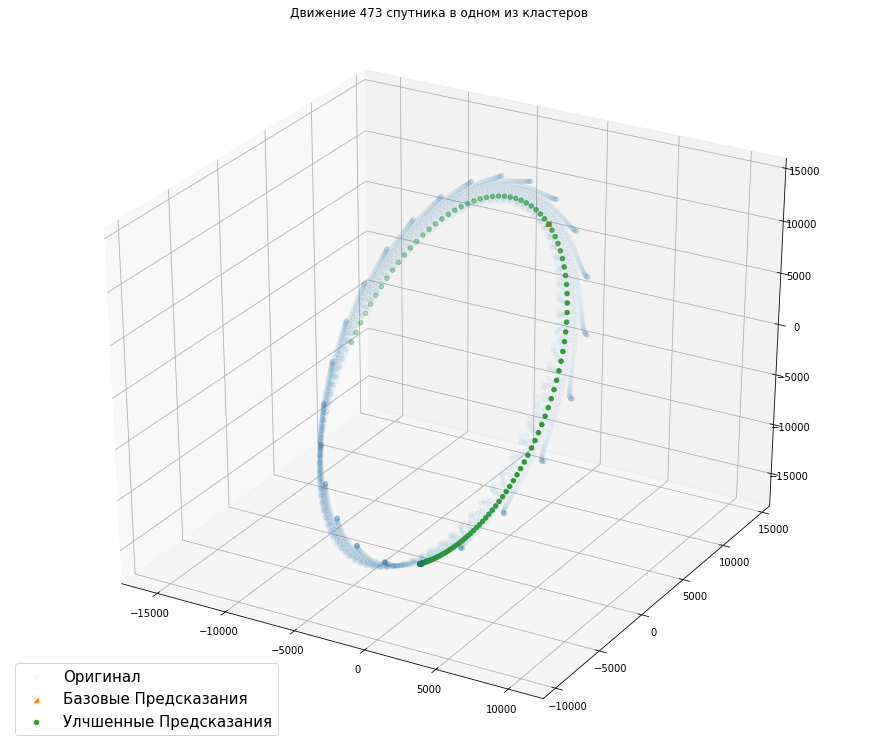

In [67]:
import time
from IPython.display import clear_output


train_score = []
test_score = []
i = 473
print("Скор этого спутника", smape(astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))
plot_path(i, astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == 9)]), True, True, 
          np.array(df[(df[:, 0].astype(int) == i) & (df[:, -2].astype(int) == 9)][:, 1:4]))



Зеленым отмечены реальные точки в кластере а оранжевым предсказание - видно что для таких спутников предсказывать последнюю точку в кластере бесполезно - слишком высокое смещение в кластере.

Это наталкивает нас на идею предсказывать смещение внутри кластера. 

Следующий предиктор делает это так - он берет последнюю точку кластера как и предыдущий, а также смотрит на последнее смещение внутри кластера (последняя точка в кластере - предпоследняя точка в кластере). 

Тоесть мы апроксимируем смещение внутри кластера просто прямой - что может напоминать линейную регрессию.

In [0]:
import copy

class Modern_Astro_Predictor(BaseEstimator):
    def __init__(self):

        self.base_data = None # копия self.sat - чтобы после окончания предикта восстановить первоначальную координату без смещения
        self.base_shift = None # словарь всех спутников где в каждом спутнике хранятся последние 24 смещения в каждом из кластеров
        self.sat = None # словарь всех спутников где в каждом спутнике хранятся последние 24 точки в каждом из кластеров
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        
        output: self
        """
        self.sat = dict(Counter(X[:, 0]))
        self.base_data = dict(Counter(X[:, 0]))
        for sat in self.sat:
          data = (X[X[:, 0] == sat])[-24:, :]
          coord_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
          sec_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
          if (X[X[:, 0] == sat]).shape[0] >= 48:
            shift = data - (X[X[:, 0] == sat])[-48:-24, :]
          else:
            shift = data * 0
          for clus in coord_dict:
            coord_dict[clus] = [(data[data[:, -2] == clus])[:, 1:7], (shift[data[:, -2] == clus])[:, 1:7]]
            sec_dict[clus] = [(data[data[:, -2] == clus])[:, 1:7], (shift[data[:, -2] == clus])[:, 1:7]]
          
      
          self.sat[sat] = coord_dict
          self.base_data[sat] = dict(sec_dict).copy()
        return self

    def predict(self, X):
        if self.sat is None:
            raise Exception('Not trained yet')
        prediction = np.ones((X.shape[0], 6))
        for i in range(X.shape[0]):
          row = X[i]
          base = self.sat[row[0]][row[-2]][0]
          if row[-3] == 0.0: # если дубликат то не делать смещения
            prediction[i] = base
            continue
          shift = self.sat[row[0]][row[-2]][1]
          prediction[i] = base + shift
          self.sat[row[0]][row[-2]][0] += self.sat[row[0]][row[-2]][1] # сохраним смещение в словаре
        for sat in self.sat:
          self.sat[sat] = Counter(copy.deepcopy(self.base_data[sat])) ## восстановим точки без смещения

        return prediction


In [71]:
modern_astro_model = Modern_Astro_Predictor()
modern_astro_model.fit(X_train, y_train)
for _ in range(3):
  prediction2 = modern_astro_model.predict(X_test)
  print(smape(prediction2, y_test))

97.12736661196637
97.12736661196637
97.12736661196637


Скор очень сильно взлетел но по некоторым спутникам он все таки упал, в дальнейшем мы будем вычислять какой алгоритм лучше подходит для конкретного спутника конкретного кластера. (Своеобразный алгоритм голосования)

Оценим визуально предсказания 2 классов на примере одного спутника.

Basic -  95.90140728702477
Modern -  99.76167257140627
Этот в Тесте !!!!!!!


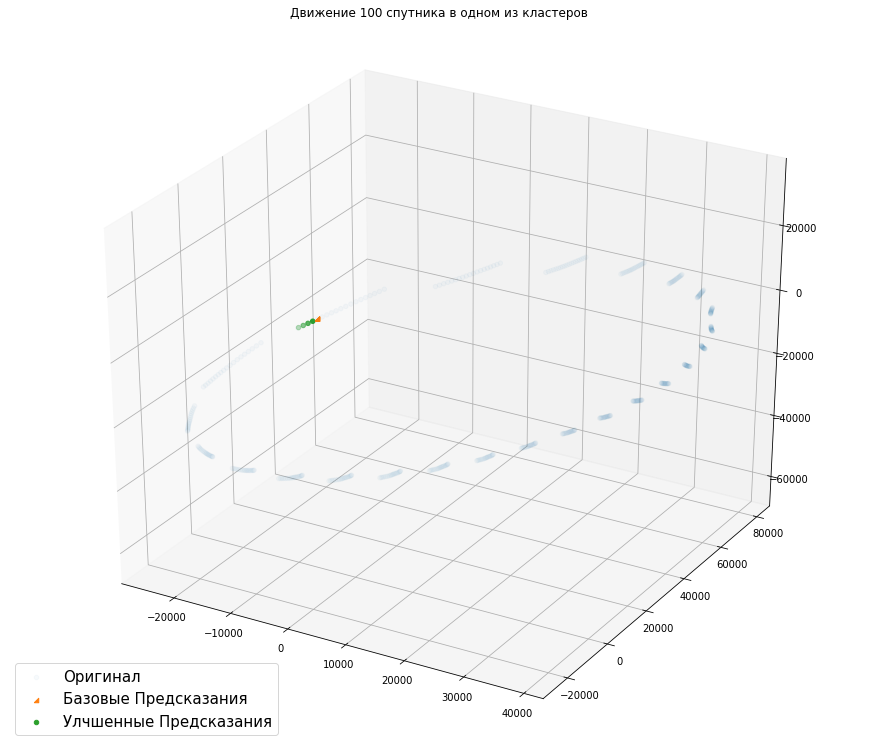

In [74]:
i = 100
clus = 8 # можно поменять
print('Basic - ', smape(astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))
print('Modern - ', smape(modern_astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))
if i in set(test_sat):
   print('Этот в Тесте !!!!!!!')
plot_path(i, astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == clus)]), True, 
          True, modern_astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == clus)]))


100 спутник хороший пример где такое базовое смещение дало очень неплохой результат. Естественно есть спутники где предсказывать смещение в виде прямой как в линейной регрессии очень неэффективно. Посмотрим на один из таких спутников. Мы его уже видели он представлен сверху, это например 473 спутник:

Basic -  47.28683523899494
Modern -  69.65864093458597


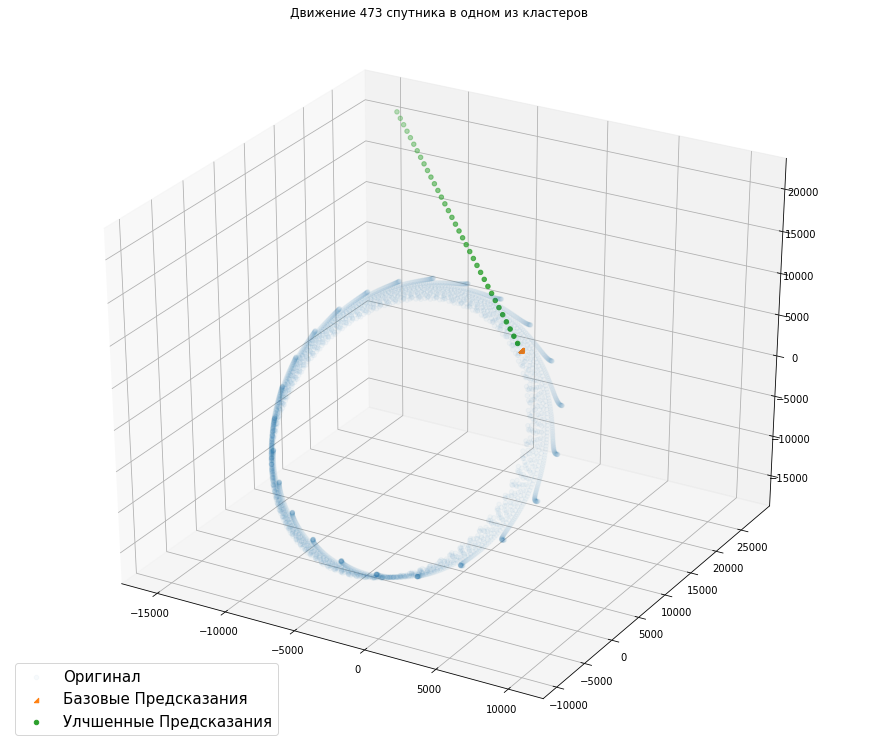

In [76]:
i = 473
clus = 8 # можно поменять
print('Basic - ', smape(astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))
print('Modern - ', smape(modern_astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))

plot_path(i, astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == clus)]), True, 
          True, modern_astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == clus)]))


Несмотря на то что скор вырос - очевидно что предсказание плохое.

Теперь у нас появляется идея предсказывать смещение в кластере не прямой а реккурентно и используя соседей. В самой базовой версии это выглядит так - 

1) У нас есть последняя точка в кластере. Надо как то предсказать ее смещение - скорее всего оно примерно такое же как у ближайших к ней точек. Опираемся на базовую идею unsupervised алгоритмов. Смещение данной точки такое же как у ее соседей

2) Искать соседей среди всех точек слишком долго но в то же время самыми актуальными для нас смещениями внутри кластера являются последние смещения. Поэтому выделим 24 точки в каждом из кластеров, только не самые первые точки, а середину кластера.

3) Среди этих 24 точек найдем самую ближайшую к нашей точке. Пользуясь обычным евклидовым расстоянием.

4) Ранее у каждой точки мы выделяли смещение до следующей точки в кластере. Возьмем это смещение и будем предполагать что это смещение будет и у нашей точки

5) Возьмем не только смещение этой ближайший точки а все смещения от этой точки и до конца кластера.

6) Теперь мы можем предсказать смещение на 15 дней. Но нам нужны еще смещения если мы хотим предсказать на месяц. Посчитаем где будет находится эта последняя точка в кластере после всех сохраненных смещений.

7) У нас получилась новая точка - последняя + все смещения у ближайшей точки до конца кластера. Поищем теперь среди тех же 24 точек ближайшего соседа новой точки.

8) Опять сохраним все смещения этого соседа до конца кластера.

9) Когда будем предсказывать у нас уже будут смещения на 30 дней вперед. Тоесть мы возьмем последнюю точку и поочередно будет суммировать к ней сохраненные смещения.

In [0]:
from tqdm import tqdm

class Basic_Rec_Astro_Predictor(BaseEstimator):
    def __init__(self):
        self.sat = None

    
    def fit(self, X, y):
        self.sat = dict(Counter(X[:, 0]))
        for sat in tqdm(self.sat, desc='basic rec'):
          if sat % 3 == 2:
            clear_output()
          
          data = (X[X[:, 0] == sat])[-24:, :] # (1)
          fst_points = (X[X[:, 0] == sat])[:24, :]
          sat_mid = (X[X[:, 0] == sat]).shape[0] // 2 
          middle_points = (X[X[:, 0] == sat])[sat_mid: sat_mid + 24, :] # (2)
          min_clus_id = int(middle_points[0, -1])
          coord_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
          shift_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
          for clus in coord_dict:
            point = data[data[:, -2] == clus]
            coord_dict[clus] = point[:, 1:7]
            second_middle_lst = [None] * 24
            middle_distance_lst = [None] * 24
            for dist in range(24):
              # для упрощения считаю квадрат расстояния
              middle_distance_lst[dist] = float(((middle_points[middle_points[:, -2] == dist][:, 1:4] - point[:, 1:4])**2).mean(axis=1))
            
            middle_nearest = middle_distance_lst.index(min(middle_distance_lst)) # (3)
            shift = np.sum((X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-6], axis=0) # (6)
            for dist in range(24):
              second_middle_lst[dist] = float(((middle_points[middle_points[:, -2] == dist][:, 1:4] - (point[:, 1:4] + shift))**2).mean(axis=1))

            nearest_cluster = second_middle_lst.index(min(second_middle_lst)) # (7)
            shift_dict[clus] = [(X[(X[:, 0] == sat) & (X[:, -2] == nearest_cluster)])[:, -9:-3], 0, 
                                (X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-3], 
                                ((X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-3]).shape[0]] # (4) (5) (8)

          
      
          self.sat[sat] = (coord_dict, shift_dict)
        return self
    
    def predict(self, X):
        """
        X: np.array of shape (l, d)
        
        output: y, np.array of shape (l)
        """
        if self.sat is None:
            raise Exception('Not trained yet')
        prediction = np.ones((X.shape[0], 6))
        for i in range(X.shape[0]):
          row = X[i]
          base = self.sat[row[0]][0][row[-2]]
          shift_ar = self.sat[row[0]][1][row[-2]]
          middle_shift_ar = shift_ar[2]
          board = shift_ar[3]
          shift_ar[1] += 1
          if row[-3] == 0.0:
            shift_ar[1] -= 1
          middle_shift = np.sum(middle_shift_ar[:min(shift_ar[1],board), :], axis=0)
          if shift_ar[1] < board:
            basic_shift = middle_shift * 0
          else:
            basic_shift = np.sum(shift_ar[0][board:shift_ar[1], :], axis=0)
          total_shift = middle_shift + basic_shift
          prediction[i] = base + total_shift # (9)
        
        for sat in self.sat:
          for clus in range(24):
            self.sat[sat][1][clus][1] = 0

        return prediction

Учиться минут 12

In [79]:
rec_astro_model = Basic_Rec_Astro_Predictor()
rec_astro_model.fit(X_train, y_train)

basic rec: 100%|██████████| 600/600 [12:40<00:00,  1.27s/it]


Basic_Rec_Astro_Predictor()

Посчитаем скор полученной модели - он получится меньше но на некоторых спутниках стало значительно лучше чем было. Посмотрим на примере 37 спутника

In [80]:
for _ in range(3):
  prediction2 = rec_astro_model.predict(X_test)
  print(smape(prediction2, y_test))

96.76557452908406
96.76557452908406
96.76557452908406


Basic_Rec -  78.97735652627922
Modern -  61.03489326540152


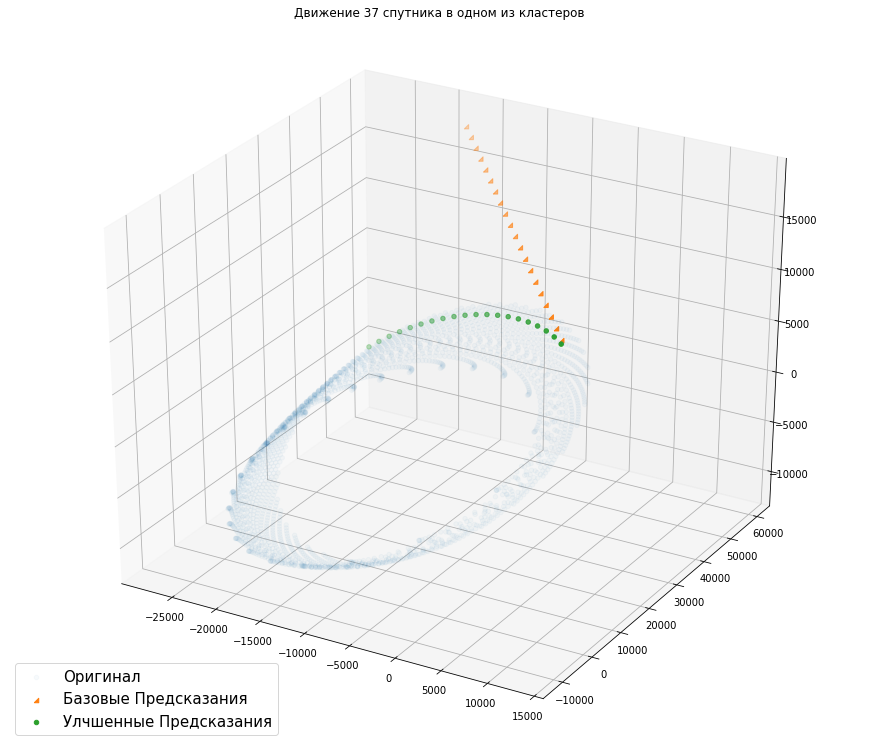

In [122]:
i = 37
clus = 8 # можно поменять

print('Basic_Rec - ', smape(rec_astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))
print('Modern - ', smape(modern_astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))

plot_path(i, modern_astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == clus)]), True, 
          True, rec_astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == clus)]))



Если посмотреть полученные предсказания Basic_rec алгоритма то можно заметить что они в целом хороши но слишко консервативны. Связано это с тем что мы опираемся изнаачально на смещения произошедщие 15 дней назад и несмотря на то что точка соседняя, спутник мог за это время ускориться или замедлиться. 

Отсюда возникает новая идея: нам нужно искать как можно более недавние ближайшие точки и сохранять уже их смещения. Методом проб и ошибок было установлено что самые оптимальные точки это после 4/5 января. Что соответствует примерно 25 января. 

Нового в данном алгоритме следующее:

* Теперь мы выделяем 24 точки не с середины а примерно на 25 января.

* Сохраним смещения на 1/5 месяца у соседа. Считаем новую точку после смещений как - последняя точка в кластере + все смещения ближайшей точки до конца кластера. И опять ищем ближайшую точку из 24 у полученной новой и сохраняем смещения

* Повторяем операцию еще 4 раза чтобы у нас были смещения на месяц

* В итоге у нас будут более актальные смещения хоть и более прерывистые

* Бывают спутники с маленьким количеством наблюдений для них ищем точки от 20 января (2/3 кластера)

In [0]:
class Strong_Rec_Astro_Predictor(BaseEstimator):
    def __init__(self):
        self.sat = None

    
    def fit(self, X, y):
        self.sat = dict(Counter(X[:, 0]))
        for sat in tqdm(self.sat, desc='Strong rec 4/5'):


          data = (X[X[:, 0] == sat])[-24:, :]
          fst_points = (X[X[:, 0] == sat])[:24, :]
          try:
              sat_mid = (X[X[:, 0] == sat]).shape[0] * 4 // 5 
              if int(sat) == 252 or int(sat) == 301:
                sat_mid = (X[X[:, 0] == sat]).shape[0] * 2 // 3
              middle_points = (X[X[:, 0] == sat])[sat_mid: sat_mid + 24, :]
              min_clus_id = int(middle_points[0, -1])
              coord_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
              shift_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
              for clus in coord_dict:
                point = data[data[:, -2] == clus]
                coord_dict[clus] = point[:, 1:7]
                second_middle_lst = [None] * 24
                middle_distance_lst = [None] * 24
                for dist in range(24):
                  middle_distance_lst[dist] = float(((middle_points[middle_points[:, -2] == dist][:, 1:4] - point[:, 1:4])**2).mean(axis=1)) # падает для спутников с малым числом наблюдений
                middle_nearest = middle_distance_lst.index(min(middle_distance_lst))
                more_shift = X[:0,-9:-3]
                for _ in range(4):
                  shift = np.sum((X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-6], axis=0) + np.sum(more_shift[:, :3], axis=0)
                  
                  for dist in range(24):
                    try:
                      second_middle_lst[dist] = float(((middle_points[middle_points[:, -2] == dist][:, 1:4] - (point[:, 1:4] + shift))**2).mean(axis=1))
                    except:
                      print(sat, clus, dist)

                  nearest_cluster = second_middle_lst.index(min(second_middle_lst))
                  more_shift = np.append(more_shift, (X[(X[:, 0] == sat) & (X[:, -2] == nearest_cluster)])[min_clus_id:, -9:-3], axis=0)
                shift_dict[clus] = [more_shift, 0, 
                                    (X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-3], 
                                    ((X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-3]).shape[0]]
                if sat % 2 == 0:
                  clear_output() # tqdm иногда ломается
              self.sat[sat] = (coord_dict, shift_dict)
          except:
            sat_mid = (X[X[:, 0] == sat]).shape[0] * 2 // 3 
            if int(sat) == 252 or int(sat) == 301:
              sat_mid = (X[X[:, 0] == sat]).shape[0] * 2 // 3
            middle_points = (X[X[:, 0] == sat])[sat_mid: sat_mid + 24, :]
            min_clus_id = int(middle_points[0, -1])
            coord_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
            shift_dict = Counter((X[X[:, 0] == sat])[-24:, -2])
            for clus in coord_dict:
              point = data[data[:, -2] == clus]
              coord_dict[clus] = point[:, 1:7]
              second_middle_lst = [None] * 24
              middle_distance_lst = [None] * 24
              for dist in range(24):
                middle_distance_lst[dist] = float(((middle_points[middle_points[:, -2] == dist][:, 1:4] - point[:, 1:4])**2).mean(axis=1)) #очень странная ошибка
              middle_nearest = middle_distance_lst.index(min(middle_distance_lst))
              more_shift = X[:0,-9:-3]
              for _ in range(2):
                shift = np.sum((X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-6], axis=0) + np.sum(more_shift[:, :3], axis=0)
                for dist in range(24):
                  try:
                    second_middle_lst[dist] = float(((middle_points[middle_points[:, -2] == dist][:, 1:4] - (point[:, 1:4] + shift))**2).mean(axis=1))
                  except:
                    print(sat, clus, dist)

                nearest_cluster = second_middle_lst.index(min(second_middle_lst))
                more_shift = np.append(more_shift, (X[(X[:, 0] == sat) & (X[:, -2] == nearest_cluster)])[min_clus_id:, -9:-3], axis=0)
            
              shift_dict[clus] = [more_shift, 0, 
                                  (X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-3], 
                                  ((X[(X[:, 0] == sat) & (X[:, -2] == middle_nearest)])[min_clus_id:, -9:-3]).shape[0]]
              clear_output()

            
        
            self.sat[sat] = (coord_dict, shift_dict)
        return self
    
    def predict(self, X):
        """
        X: np.array of shape (l, d)
        
        output: y, np.array of shape (l)
        """
        if self.sat is None:
            raise Exception('Not trained yet')
        prediction = np.ones((X.shape[0], 6))
        for i in range(X.shape[0]):
          row = X[i]

          base = self.sat[row[0]][0][row[-2].astype(int)]
          shift_ar = self.sat[row[0]][1][row[-2]]
          middle_shift_ar = shift_ar[2]
          board = shift_ar[3]
          shift_ar[1] += 1
          if row[-3] == 0.0:
            shift_ar[1] -= 1
          middle_shift = np.sum(middle_shift_ar[:min(shift_ar[1],board), :], axis=0)
          if shift_ar[1] < board:
            basic_shift = middle_shift * 0
          else:
            basic_shift = np.sum(shift_ar[0][:shift_ar[1] - board, :], axis=0)
          total_shift = middle_shift + basic_shift
          prediction[i] = base + total_shift
        
        for sat in self.sat:
          for clus in range(24):
            self.sat[sat][1][clus][1] = 0

        return prediction

Учится полчаса

In [125]:
strong_astro_model = Strong_Rec_Astro_Predictor()
strong_astro_model.fit(X_train, y_train)

Strong rec 4/5: 100%|██████████| 600/600 [30:46<00:00,  3.10s/it]


Strong_Rec_Astro_Predictor()

In [126]:
for _ in range(3):
  prediction2 = strong_astro_model.predict(X_test)
  print(smape(prediction2, y_test))

97.94573765986485
97.94573765986485
97.94573765986485


Перепроверим на 37 спутнике

Basic_Rec -  78.97735652627922
Strong_Rec -  84.46656705089785


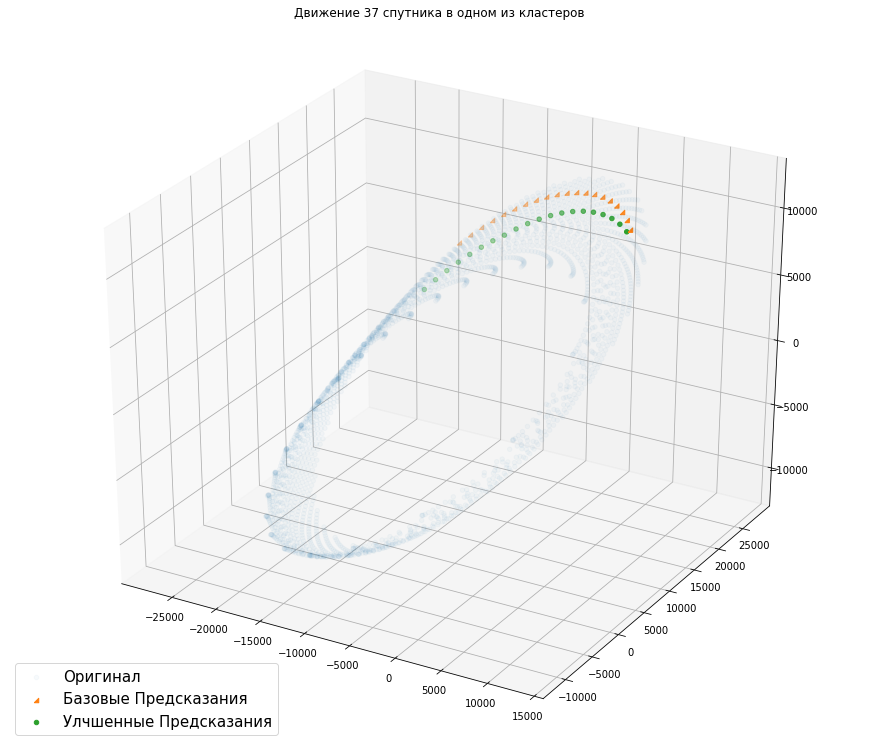

In [127]:
i = 37
clus = 8 # можно поменять

print('Basic_Rec - ', smape(rec_astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))
print('Strong_Rec - ', smape(strong_astro_model.predict(X_test[X_test[:, 0].astype(int) == i]), y_test[X_test[:, 0].astype(int) == i]))

plot_path(i, rec_astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == clus)]), True, 
          True, strong_astro_model.predict(X_test[(X_test[:, 0].astype(int) == i) & (X_test[:, -2].astype(int) == clus)]))

Теперь у нас есть 4 разных алгоритма - будем их использовать при стекинге и голосовании. Для начала создадим базовый алгоритм голосования - будем сравнивать для каждого спутника каждого кластера лучший из 4 алгоритмов. Номер этого алгоритма будет в словаре solution. Потом функция reshala - будет на основе этого словаря выбирать нужное предсказание из 4.

In [0]:
def voting(all_prediction, real_values, identifier):
  '''
  all_prediction - list of prediction
  real_values - value of XYZ...
  identifier - array of sat_id and id of prediction

  return словарь в котором указано какой алгоритм лучше предсказывает конкретный спутник
  '''

  solution = dict(Counter(train.sat_id))
  for sat in tqdm(solution, desc='solve'):
    solution[sat] = [None] * 24
    for clus in range(24):
      mask = (identifier[:, 0] == sat) & (identifier[:, -1].astype(int) == clus)
      score = []
      
      for pred in all_prediction:
        score.append(smape(pred[mask], real_values[mask]))
      solution[sat][clus] = score.index(max(score))
  return solution

def reshala(all_prediction, solution, identifier):
  final = copy.deepcopy(all_prediction[0])
  for i in range(final.shape[0]):
    algo_num = solution[identifier[i, 0]][identifier[i, -1].astype(int)]

    #print(identifier.shape)
    final[i] = all_prediction[algo_num][i]
  return final

Если ранее все ячейки были запущены и вам не хочется ждать 45 минут в комментах указано какие ячейки можно закомментить.

In [0]:
astro_model = Astro_Predictor()
astro_model.fit(X_train, y_train)
prediction = astro_model.predict(X_test)
modern_astro_model = Modern_Astro_Predictor()
modern_astro_model.fit(X_train, y_train)
prediction2 = modern_astro_model.predict(X_test)
rec_astro_model = Basic_Rec_Astro_Predictor() # чтобы не ждать можно закомментить если ранее все ячейки были запущены !!!!
rec_astro_model.fit(X_train, y_train) # учиться 12 минут # чтобы не ждать можно закомментить если ранее все ячейки были запущены !!!!
pred3 = rec_astro_model.predict(X_test)
strong_astro_model = Strong_Rec_Astro_Predictor()# чтобы не ждать можно закомментить если ранее все ячейки были запущены !!!!
strong_astro_model.fit(X_train, y_train) # учиться полчаса # чтобы не ждать можно закомментить если ранее все ячейки были запущены !!!!
pred4 = strong_astro_model.predict(X_test)


In [130]:
solution = voting([prediction, prediction2, pred3, pred4], y_test, X_test[:, [0, -1, -2]])
final_pred = reshala([prediction, prediction2, pred3, pred4], solution, X_test[:, [0, -1, -2]])
smape(final_pred, y_test)

solve: 100%|██████████| 600/600 [00:52<00:00, 11.44it/s]


98.19078939196886

Скор уже получился очень не плохим но попробуем улучшить простое голосование. 

Попробуем усовершенствовать голосование, и вместо простого выбора алгоритма на спутник воспользуемся градиентным бустингом. 
* В конечном итоге дал очень слабый прирост на паблике и из-за него меньше баллов получили на привате

In [133]:
!pip install catboost
from catboost import CatBoostRegressor

def catboost_voting(all_pred, additional_data, real_values, test_data, test_pred):
  result = copy.deepcopy(test_pred[0])
  #test_data = test_data[:, [0, -1, -2]]
  for col in range(6):
    train_data = all_pred[0][:, col: col + 1]
    test = test_pred[0][:, col: col + 1]
    for pred in range(len(all_pred)):
      if pred == 0:
        continue
      #print(train_data)
      train_data = np.append(train_data, all_pred[pred][:, col: col + 1], axis=1)
      test = np.append(test, test_pred[pred][:, col: col + 1], axis=1)
    train_data = np.append(train_data, additional_data, axis=1)
    test = np.append(test, test_data, axis=1)
    catboost = CatBoostRegressor()
    catboost.fit(train_data, real_values[:, col])
    pred = catboost.predict(test)
    result[:, col] = pred
    clear_output()

  return result


modified_pred = catboost_voting([prediction, prediction2, pred3, pred4, final_pred], X_test[:, [0, -1, -2]], y_test, X_test[:, [0, -1, -2]], [prediction, prediction2, pred3, pred4, final_pred])
smape(modified_pred, y_test)

97.42632975290594

In [134]:
solution = voting([prediction, prediction2, pred3, pred4, modified_pred], y_test, X_test[:, [0, -1, -2]])
final_pred_boost = reshala([prediction, prediction2, pred3, pred4, modified_pred], solution, X_test[:, [0, -1, -2]])
smape(final_pred_boost, y_test)

solve: 100%|██████████| 600/600 [01:04<00:00,  8.74it/s]


99.00122224824584

Скор повысился.

Теперь мы готовы обучать конечную модель

In [136]:
astro_model = Astro_Predictor()
astro_model.fit(df, y)
modern_astro_model = Modern_Astro_Predictor()
modern_astro_model.fit(df, y)
rec_astro_model = Basic_Rec_Astro_Predictor()
rec_astro_model.fit(df, y) # 3 минуты на колабе
strong_astro_model = Strong_Rec_Astro_Predictor()
strong_astro_model.fit(df, y) # 7 минут на колабе

Strong rec 4/5: 100%|██████████| 600/600 [07:15<00:00,  1.39it/s]


Strong_Rec_Astro_Predictor()

# Засабмитим результат

In [0]:
test = test.fillna(0)

test_feat = [test.sat_id,
            test.x_sim,
            test.y_sim,
            test.z_sim,
            test.Vx_sim,
            test.Vy_sim,
            test.Vz_sim,
            test.id,

            test.day,
            test.year,
            test.month,
            test.hour,
            test.minute,
            test.weekday,
            test.minute_from_previous,
            test.second_from_previous,            
            test.cluster,
            test.cluster_id]

test_data = np.array(test_feat).T

In [138]:
test_prediction = astro_model.predict(test_data)
test_prediction2 = modern_astro_model.predict(test_data)
test_pred3 = rec_astro_model.predict(test_data)
test_pred4 = strong_astro_model.predict(test_data)


test_boost = catboost_voting([prediction, prediction2, pred3, pred4], X_test[:, [0, -1, -2]], y_test, test_data[:, [0, -1, -2]], [test_prediction, test_prediction2, test_pred3, test_pred4])
solution_final = voting([prediction, prediction2, pred3, pred4, modified_pred], y_test, X_test[:, [0, -1, -2]])

submit_pred = reshala([test_prediction, test_prediction2, test_pred3, test_pred4, test_boost], solution_final, test_data[:, [0, -1, -2]])


solve: 100%|██████████| 600/600 [01:05<00:00,  9.40it/s]


In [0]:
#normal_id = pd.read_csv('IDAO 2020/Track 1/test.csv').id

submission = pd.DataFrame(submit_pred, columns=['x', 'y', 'z', 'Vx', 'Vy', 'Vz'])
submission = pd.concat([test.id, submission], axis=1)
submission.to_csv('submit_fst.csv', index_label=False, index=False)

In [141]:
submission.head(20)

,id,x,y,z,Vx,Vy,Vz
0,3927,-24777.771927,-10889.218299,6497.111264,2.616010,-1.310759,1.092292
1,3928,-21087.016879,-12384.242098,7839.865505,3.219176,-0.994516,0.895776
2,3929,-16579.725175,-13379.146361,8805.882071,3.877841,-0.539675,0.601805
3,3930,-11202.552105,-13655.766954,9298.304966,4.582855,0.157089,0.134774
4,3931,-4933.912532,-12796.074210,9014.887726,5.251568,1.293502,-0.653371
5,3932,1967.936813,-10015.373286,7371.893676,5.431647,3.260156,-2.070931
6,3933,7875.324635,-4071.287695,3378.546119,3.148223,6.095102,-4.253106
7,3934,8272.420796,4216.255158,-2614.343606,-2.518326,6.068129,-4.538928
8,3935,3104.861969,10197.953397,-7231.796708,-4.941009,3.358955,-2.701466
9,3936,-3323.702208,13162.666124,-9726.189603,-4.991602,1.468738,-1.331854


In [143]:
submission.tail(20)

,id,x,y,z,Vx,Vy,Vz
284051,1231045,-24965.972123,-61321.040720,6660.159613,-1.658375,1.836103,-0.033996
284052,1231046,-35932.534813,-44800.392836,6312.123882,-1.278696,2.508691,-0.113096
284053,1231047,-42909.134137,-24707.494689,4943.763349,-0.523311,3.137763,-0.216686
284054,1231048,-42222.982626,76.170033,2901.686432,0.814568,3.495135,-0.337243
284055,1231049,-29729.284283,24588.881529,80.011198,2.525851,2.877642,-0.407951
284056,1231050,-7094.705036,39979.985903,-2726.584541,3.467793,1.269023,-0.342110
284057,1231051,18318.770038,43433.608951,-4762.553578,3.297810,-0.236586,-0.208980
284058,1231052,40398.634423,38026.738293,-5853.172310,2.669954,-1.138617,-0.092739
284059,1231053,57693.664594,27764.207975,-6241.151680,1.996808,-1.596144,-0.008775
284060,1231054,70159.749404,15143.956544,-6080.384442,1.402678,-1.799927,0.048920
